<a href="https://colab.research.google.com/github/wendianaxu/speech-emotion-recognition/blob/main/training_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/wendianaxu/speech-emotion-recognition.git

Cloning into 'speech-emotion-recognition'...
remote: Enumerating objects: 1525, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 1525 (delta 22), reused 31 (delta 9), pack-reused 1469
Receiving objects: 100% (1525/1525), 213.92 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Updating files: 100% (1445/1445), done.


In [ ]:
# copy directory to drive
!cp -r "/content/speech-emotion-recognition" "/content/drive/MyDrive"

In [ ]:
# test: load an audio file, extract mfccs, and visualize

test_file = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/Actor_01/03-01-01-01-01-02-01.wav"
n_mfcc = 30
sr = 22050 # sampling rate


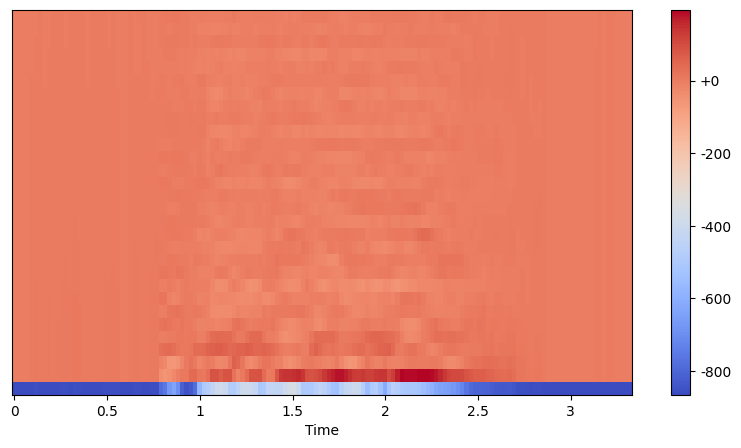

In [ ]:
# visualize mfccs
audio, sampling_rate = librosa.load(test_file, sr=sr, duration=None)
test_mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

plt.figure(figsize=(10, 5))
librosa.display.specshow(test_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
# function for loading an audio file
data_path = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/"
def load_file(path):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  # trim out silent moments from the audio
  audio, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)

  # unify sizes

  return mfccs

load_file(test_file).shape

(30, 53)

In [ ]:
# find out the max time length of trimmed audio files
def find_max_len(path):
  max_len = 0 # max duration of trimmed data
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              features_len = features.shape[1]
              if max_len < features_len:
                max_len = features_len
  return max_len

In [ ]:
max_len = 0
max_len = find_max_len(data_path)
max_len

144

In [ ]:
# redefine load_file() so that all feature matrices have the size (n_mfccs, max_len)
def load_file(path):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  # trim out silent moments from the audio
  audio, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)

  # unify sizes
  if max_len > mfccs.shape[1]: # pad matrices that are shorter than max_len
    pad_width = max_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

  return mfccs

In [ ]:
def preprocess_data(path):
  '''
  Preprocess data in all folders within the dataset. 
  '''
  X = []
  y = []
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              emotion = file.split('-')[2] # get emotion labels
                  
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              X.append(features)
              y.append(int(emotion))
  return np.array(X), np.array(y)

In [ ]:
X, y = preprocess_data(data_path)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 30, 144)
Shape of y: (1440,)


In [ ]:
# one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

In [ ]:
# alternatively: just use integer labels instead of one-hot encoding
emotions = {
    "Neutral": 1, 
    "Calm": 2, 
    "Happy": 3,
    "Sad": 4,
    "Angry": 5, 
    "Fearful": 6, 
    "Disgust": 7, 
    "Surprised": 8
}

In [ ]:
# save X, y
np.save('/content/drive/MyDrive/speech-emotion-recognition/X_2d.npy', X)
np.save('/content/drive/MyDrive/speech-emotion-recognition/y.npy', y)

In [ ]:
# save y (integer labels)
np.save('/content/drive/MyDrive/speech-emotion-recognition/y_integer.npy', y)

In [ ]:
# load X, y
X = np.load('/content/drive/MyDrive/speech-emotion-recognition/X.npy')
y = np.load('/content/drive/MyDrive/speech-emotion-recognition/y.npy')
print(X.shape, y.shape)

(1440, 13) (1440, 8)


In [ ]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [ ]:
# CNN with torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchsummary import summary
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform preprocessed data to Dataset class
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor

# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1) # add channel = 1
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1) # add channel = 1
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 


In [ ]:
X_train.shape

torch.Size([1152, 1, 13])

In [ ]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [ ]:
X, y = next(iter(train_loader))
print(X.shape, y.shape) 

torch.Size([16, 1, 30, 144]) torch.Size([16, 8])


In [ ]:
# training loop
import torch.optim as optim
train_history = []
test_history = []

def train(model, k_epochs = 1, print_every = 40):

    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    correct, total, accuracy = 0, 0, 0

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # for printing accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels
            accuracy = correct/total


            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
              print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}, accuracy:{accuracy:.3f}')
              running_loss = 0.0
          
        # append accuracy for each epoch
        train_history.append(accuracy)

        with torch.no_grad():
          for i, data in enumerate(test_loader, 0):
            correct, total, accuracy = 0, 0, 0
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels
            accuracy = correct/total
            
        test_history.append(accuracy)


    print('Finished Training')



In [ ]:
# testing loop
def test(model, data_loader):
    correct, total = 0, 0
    
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels

    print(f'Test accuracy: {100 * correct // total} %')


In [ ]:
# model1
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model1 = ConvNet().to(device)

In [ ]:
# train model1
train_history, test_history = [], []
train(model1, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.043, accuracy:0.191
[epoch: 2, batches:    40], loss: 1.809, accuracy:0.290
[epoch: 3, batches:    40], loss: 1.537, accuracy:0.370
[epoch: 4, batches:    40], loss: 1.434, accuracy:0.425
[epoch: 5, batches:    40], loss: 1.215, accuracy:0.514
[epoch: 6, batches:    40], loss: 1.127, accuracy:0.537
[epoch: 7, batches:    40], loss: 1.006, accuracy:0.604
[epoch: 8, batches:    40], loss: 0.844, accuracy:0.669
[epoch: 9, batches:    40], loss: 0.793, accuracy:0.674
[epoch: 10, batches:    40], loss: 0.674, accuracy:0.727
[epoch: 11, batches:    40], loss: 0.574, accuracy:0.782
[epoch: 12, batches:    40], loss: 0.489, accuracy:0.823
[epoch: 13, batches:    40], loss: 0.503, accuracy:0.819
[epoch: 14, batches:    40], loss: 0.349, accuracy:0.880
[epoch: 15, batches:    40], loss: 0.377, accuracy:0.861
[epoch: 16, batches:    40], loss: 0.224, accuracy:0.934
[epoch: 17, batches:    40], loss: 0.162, accuracy:0.968
[epoch: 18, batches:    40], loss: 0.197

In [ ]:
# test model1
test(model1, test_loader)

Test accuracy: 53 %


In [ ]:
# visualize testing vs. training accuracy
import matplotlib.pyplot as plt

def plot_accuracy(train_history, test_history, k_epochs):
    # Create figure and axis objects
    fig, ax = plt.subplots()

    # Plot the training and validation accuracy curves
    ax.plot(np.arange(k_epochs)+1, train_history, label='Training Accuracy')
    ax.plot(np.arange(k_epochs)+1, test_history, label='Validation Accuracy')

    # Set axis labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')

    # Set axis limits and ticks
    ax.set_ylim([0, 1])
    ax.set_xticks(np.arange(1, k_epochs+1, 3))

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

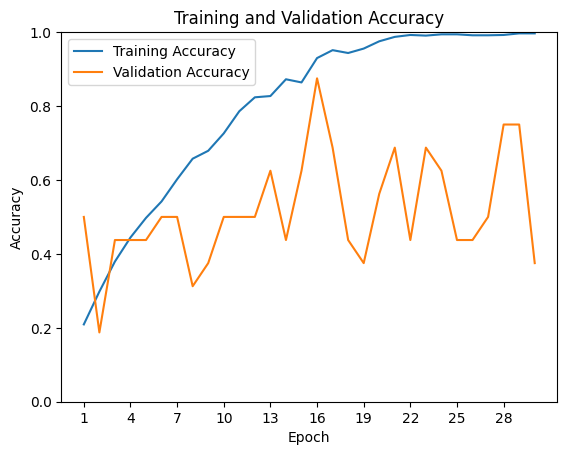

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model2: with dropout
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model2 = ConvNet().to(device)

In [ ]:
train(model2, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.223, accuracy:0.163
[epoch: 1, batches:    40], loss: 1.957, accuracy:0.181
[epoch: 1, batches:    60], loss: 1.930, accuracy:0.197
[epoch: 2, batches:    20], loss: 1.794, accuracy:0.224
[epoch: 2, batches:    40], loss: 1.762, accuracy:0.234
[epoch: 2, batches:    60], loss: 1.732, accuracy:0.237
[epoch: 3, batches:    20], loss: 1.801, accuracy:0.246
[epoch: 3, batches:    40], loss: 1.732, accuracy:0.245
[epoch: 3, batches:    60], loss: 1.768, accuracy:0.250
[epoch: 4, batches:    20], loss: 1.666, accuracy:0.258
[epoch: 4, batches:    40], loss: 1.698, accuracy:0.263
[epoch: 4, batches:    60], loss: 1.645, accuracy:0.268
[epoch: 5, batches:    20], loss: 1.605, accuracy:0.277
[epoch: 5, batches:    40], loss: 1.589, accuracy:0.281
[epoch: 5, batches:    60], loss: 1.514, accuracy:0.286
[epoch: 6, batches:    20], loss: 1.601, accuracy:0.292
[epoch: 6, batches:    40], loss: 1.536, accuracy:0.295
[epoch: 6, batches:    60], loss: 1.559, accurac

In [ ]:
test(model2, test_loader)

Test accuracy: 44 %


In [ ]:
# model3: with dropout, different linear layers
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(32)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 102, 128)
    self.fc2 = nn.Linear(128, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))

    x = self.fc2(x)
    return x

model3 = ConvNet().to(device)

In [ ]:
train_history, test_history = [], []
train(model3, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.042, accuracy:0.231
[epoch: 2, batches:    40], loss: 1.725, accuracy:0.328
[epoch: 3, batches:    40], loss: 1.480, accuracy:0.442
[epoch: 4, batches:    40], loss: 1.353, accuracy:0.479
[epoch: 5, batches:    40], loss: 1.287, accuracy:0.498
[epoch: 6, batches:    40], loss: 1.214, accuracy:0.553
[epoch: 7, batches:    40], loss: 1.111, accuracy:0.585
[epoch: 8, batches:    40], loss: 1.004, accuracy:0.636
[epoch: 9, batches:    40], loss: 0.924, accuracy:0.633
[epoch: 10, batches:    40], loss: 0.868, accuracy:0.654
[epoch: 11, batches:    40], loss: 0.784, accuracy:0.709
[epoch: 12, batches:    40], loss: 0.735, accuracy:0.720
[epoch: 13, batches:    40], loss: 0.695, accuracy:0.730
[epoch: 14, batches:    40], loss: 0.640, accuracy:0.747
[epoch: 15, batches:    40], loss: 0.602, accuracy:0.770
[epoch: 16, batches:    40], loss: 0.610, accuracy:0.764
[epoch: 17, batches:    40], loss: 0.604, accuracy:0.793
[epoch: 18, batches:    40], loss: 0.416

In [ ]:
test(model3, test_loader)

Test accuracy: 57 %


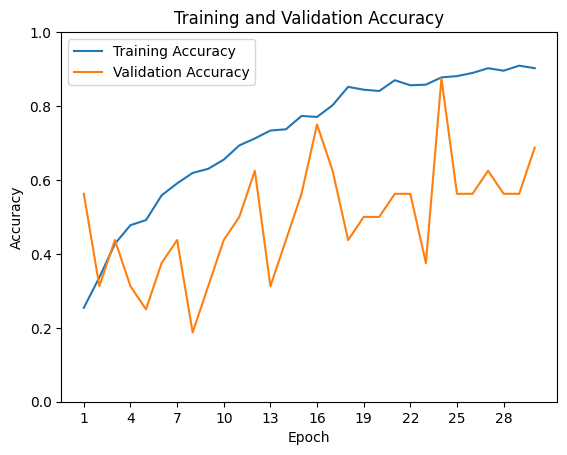

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model4
class ConvNet(nn.Module):
    def __init__(self, input_len):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (((input_len - 2) // 2 - 2) // 2), 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_len = 30  # input_len is the n_mfcc
model4 = ConvNet(input_len).to(device)

In [ ]:
train_history, test_history = [], []
train(model4, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.007, accuracy:0.178
[epoch: 2, batches:    40], loss: 1.783, accuracy:0.299
[epoch: 3, batches:    40], loss: 1.599, accuracy:0.415
[epoch: 4, batches:    40], loss: 1.517, accuracy:0.448
[epoch: 5, batches:    40], loss: 1.455, accuracy:0.463
[epoch: 6, batches:    40], loss: 1.348, accuracy:0.512
[epoch: 7, batches:    40], loss: 1.281, accuracy:0.538
[epoch: 8, batches:    40], loss: 1.185, accuracy:0.587
[epoch: 9, batches:    40], loss: 1.148, accuracy:0.566
[epoch: 10, batches:    40], loss: 1.070, accuracy:0.602
[epoch: 11, batches:    40], loss: 1.026, accuracy:0.628
[epoch: 12, batches:    40], loss: 0.870, accuracy:0.678
[epoch: 13, batches:    40], loss: 0.885, accuracy:0.680
[epoch: 14, batches:    40], loss: 0.775, accuracy:0.710
[epoch: 15, batches:    40], loss: 0.789, accuracy:0.720
[epoch: 16, batches:    40], loss: 0.738, accuracy:0.738
[epoch: 17, batches:    40], loss: 0.677, accuracy:0.767
[epoch: 18, batches:    40], loss: 0.643

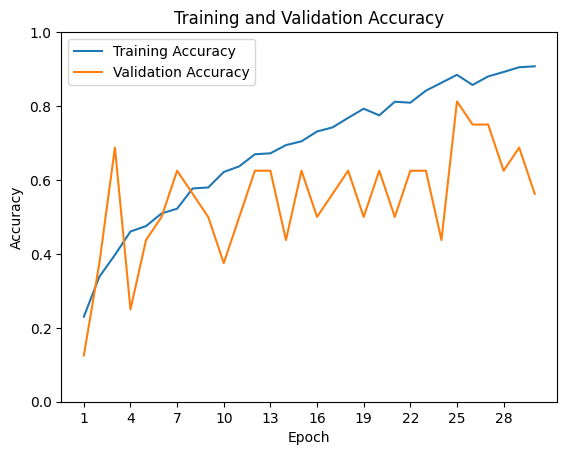

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# 1d model 1

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
    self.bn1 = nn.BatchNorm1d(32)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2)
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model5 = ConvNet().to(device)

In [ ]:
train_history, test_history = [], []
train(model5, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.009, accuracy:0.194
[epoch: 2, batches:    40], loss: 2.011, accuracy:0.189
[epoch: 3, batches:    40], loss: 2.023, accuracy:0.165
[epoch: 4, batches:    40], loss: 2.016, accuracy:0.174
[epoch: 5, batches:    40], loss: 1.997, accuracy:0.192
[epoch: 6, batches:    40], loss: 1.986, accuracy:0.215
[epoch: 7, batches:    40], loss: 1.995, accuracy:0.192
[epoch: 8, batches:    40], loss: 1.989, accuracy:0.192
[epoch: 9, batches:    40], loss: 1.990, accuracy:0.192
[epoch: 10, batches:    40], loss: 1.987, accuracy:0.210
[epoch: 11, batches:    40], loss: 2.010, accuracy:0.192
[epoch: 12, batches:    40], loss: 1.971, accuracy:0.206
[epoch: 13, batches:    40], loss: 1.975, accuracy:0.207
[epoch: 14, batches:    40], loss: 1.982, accuracy:0.226
[epoch: 15, batches:    40], loss: 1.973, accuracy:0.212
[epoch: 16, batches:    40], loss: 1.959, accuracy:0.226
[epoch: 17, batches:    40], loss: 1.962, accuracy:0.198
[epoch: 18, batches:    40], loss: 1.982

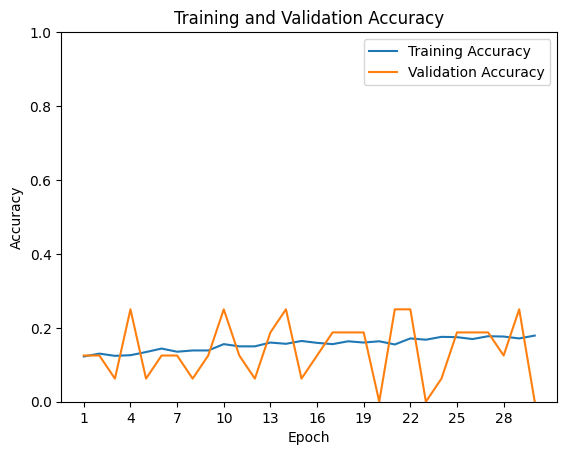

In [ ]:
plot_accuracy(train_history, test_history, 30)